## Imports

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

## Objective function definition

In [2]:
# definition of eggholder function
# global minimum: -959.6407

def obj_func(x):
    x1 = x[0]
    x2 = x[1]
    return -1 * (
        -1 * (x2 + 47) * np.sin(np.sqrt(np.abs(x2 + x1 / 2 + 47)))
        - x1 * np.sin(np.sqrt(np.abs(x1 - (x2 + 47))))
    )

#### Plot

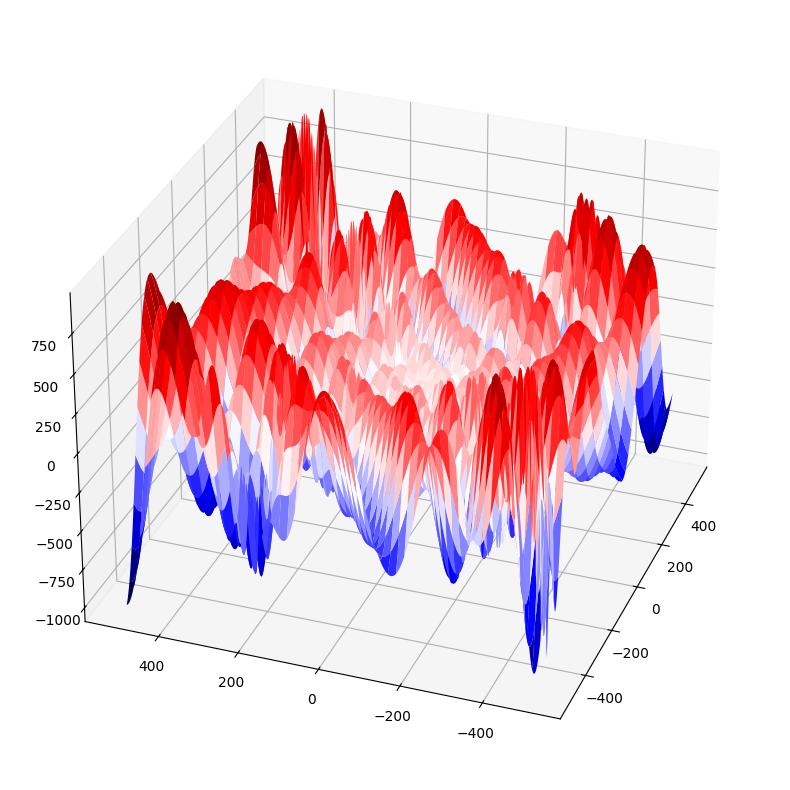

In [3]:
n = 1000
sampled = np.linspace(-512, 512, n)
x, y = np.meshgrid(sampled, sampled)
z = np.zeros((len(sampled), len(sampled)))

for i in range(len(sampled)):
    for j in range(len(sampled)):
        z[i, j] = obj_func(np.array([x[i, j], y[i, j]]))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(x, y, z, cmap="seismic", linewidth=0.4, antialiased=True)
ax.view_init(30, 200)
plt.show()

## Method implementation

In [4]:
# number of variables
N = 2

# variables range (min, max)
a = -512
b = 512

In [5]:
# function that finds number of bits needed, also returns coding accuracy
def nbits(a, b, dx):
    B = int(abs(b - a) / dx + 1).bit_length()
    dx_new = abs(b - a) / (2**B - 1)
    return B, dx_new

# function that generates random population
def gen_population(P, N, B):
    pop = np.random.randint(2, size=(P, N * B))
    return pop

# function that decodes bits of individual
def decode_individual(individual, N, B, a, dx):
    decode_individual = individual.reshape((N, B)).dot(1 << np.arange(B)[::-1]) * dx + a
    return decode_individual

# function that evaluates all individuals in population
def evaluate_population(func, pop, N, B, a, dx):
    evaluated_pop = np.apply_along_axis(
        lambda x: func(decode_individual(x.astype(np.float64), N, B, a, dx)), 1, pop
    )
    return evaluated_pop

# function that implement roulette method for choosing individuals to survive
def roulette(pop, evaluated_pop):
    evaluated_pop += np.absolute(evaluated_pop.min()) + 1
    evaluated_pop /= np.sum(evaluated_pop)
    new_pop_ind = np.random.choice(pop.shape[0], size=pop.shape[0], p=evaluated_pop)
    new_pop = pop[new_pop_ind, :]
    return new_pop

# function that implements crossing
def cross(pop, pk):
    ind = 0
    m = pop.shape[0]
    n = pop.shape[1]
    new_pop = np.array([None] * m * n).reshape((m, n))

    if m % 2 == 1:
        np.copyto(new_pop[0], pop[0])
        ind += 1

    for i in range(ind, m, 2):
        if random.uniform(0, 1) < pk:
            np.copyto(new_pop[i], np.append(pop[i][: n // 2], pop[i + 1][n // 2 :]))
            np.copyto(new_pop[i + 1], np.append(pop[i + 1][: n // 2], pop[i][n // 2 :]))
        else:
            np.copyto(new_pop[i], pop[i])
            np.copyto(new_pop[i + 1], pop[i + 1])

    return new_pop

# function that implements mutation
def mutate(pop, pm):
    new_pop = np.bitwise_xor(
        pop, np.random.choice([1, 0], size=pop.shape, p=[pm, 1 - pm])
    )
    return new_pop

In [6]:
# population size
pop_size = 50

# probability of crossing
pk = 0.7

# probability of mutation
pm = 0.01

# number of genetations
generations = 100

# assumed coding accuracy
dx = 1e-10

In [7]:
def evolve(fun, pop_size, px, pm, generations, dx):
    B, dx2 = nbits(a, b, dx)

    # generate starting population
    pop = gen_population(pop_size, N, B)

    # evaluate individuals in population
    oc = evaluate_population(obj_func, pop, N, B, a, dx2)

    # find and save best solution
    best_sol = np.max(oc)
    best_generation = 1
    best_sol_arg = decode_individual(pop[np.argmax(oc)], N, B, a, dx2)

    # statistics update
    list_best = [-best_sol]
    list_best_generation = [-best_sol]
    list_mean = [-np.mean(oc)]

    for i in range(generations):
        # selection
        pop = roulette(pop, oc)

        # crossing
        pop = cross(pop, pk)

        # mutation
        pop = mutate(pop, pm)

        # evaluate individuals in population
        oc = evaluate_population(obj_func, pop, N, B, a, dx2)

        # find and save best solution if it's better than currently the best one
        val = np.max(oc)
        val_arg = decode_individual(pop[np.argmax(oc)], N, B, a, dx2)
        if val > best_sol:
          best_sol = val
          best_generation = i+2

        # statistics update
        list_best.append(-best_sol)
        list_best_generation.append(-val)
        list_mean.append(-np.average(oc))

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(122)
    ax.plot(list_best)
    ax.plot(list_best_generation)
    ax.plot(list_mean)

    return -best_sol, best_generation, list_best, list_best_generation, list_mean

## Execution

Best solution found: -950.6998610692184


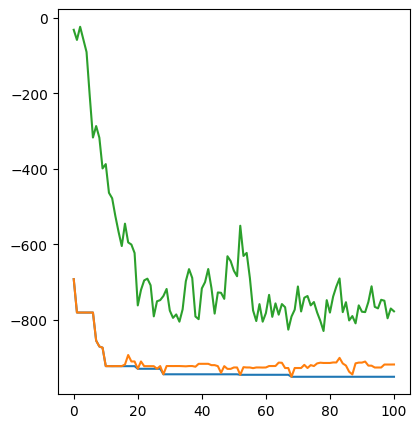

In [10]:
res = evolve(obj_func, pop_size, pk, pm, generations, dx)
print("Best solution found:", res[0])